In [66]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import keplergl
import pickle
import pandas as pd
import time

from collections import OrderedDict
from pyproj import Proj
from h3 import h3

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from geopandas import GeoSeries, GeoDataFrame
from rtree import index

from utils.OSRMFramework import OSRMFramework
from utils.RouteAnnotator import RouteAnnotator
from utils.lines import plot_linestring
from utils.conversor import latlon2linestring

%load_ext autoreload
%autoreload 2

###### constants
TARGET = 'fare_amount'
OSRM_PATH = 'localhost:5000'
DATASET_PATH = 'data/taxi_fare_sample_100000.csv'
H3_RES_ANALYSIS = 7



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------
Notebook for AMLD 2020 Workshop: [Feature Engineering for Spatial Data Analysis](https://appliedmldays.org/workshops/feature-engineering-for-spatial-data-analysis).  
  
Authors:  
* Caio Miyashiro: caiohenrique37@gmail.com  
* Eva Jaumann: eva.jaumann@mytaxi.com  
* Selim Onat: selim.onat@mytaxi.com  

Github Repository: https://github.com/caiomiyashiro/geospatial_data_analysis/tree/master/AMLD-2020  

---------------
  
# Introduction
  
Welcome to the workshop! Today you're going to learn several techniques related to the processing of geospatial data. We're going to use as background motivation the Kaggle dataset on [Prediction of Taxis Fares](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) but our main goal is for you to learn the concepts and techniques on how to process such kind of datasets. We'll iteratively build models with higher level features and go through the concepts oh what do they mean and how were they created. At the end, we're going to check one more advanced example on how we can make use of mobility data in order to calculate and incorporate traffic information to your feature engineering processes. This is the overview:

## TODO: Beautiful diagram with overview of what participants will be seeing

## Dataset

<img src="images/kaggle_page.png" width="700"> 
<center>Kaggle Taxi Prediction Homepage Picture</center>  

The challenge of this dataset is the predict the final fare paid by user by just having a small set of variables to work with:
* **pickup_datetime**: Time that a user was picked-up by a taxi
* **pickup_latitude**:   pickup location
* **pickup_longitude**:  pickup location
* **dropoff_latitude**:  drop-off location
* **dropoff_longitude**: drop-off location   
* **passenger_count**: amount of passengers in this trip
  
This creates a few challenges, as we don't exactly know the route that the driver took. This means that any fixed taxes or tolls are not explicited coded as variables, so we'll see a few ways to try to identify these hidden features.  

<div class="alert alert-block alert-info">
    The main focus of this workshop will be <b>not</b> about minimizing your model error score, but rather to explain to you the main concepts and techniques when working with spatial data :)
</div>
  
The original dataset is big (> 5Gb of data), so we randomly sampled and made it available for you. Lets take a look at it:


In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/caiomiyashiro/geospatial_data_analysis/master/data/sample_100000.csv')
df = pd.read_csv(DATASET_PATH)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
display(df.head())
display(df.dtypes)
display(df.describe())



,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.1,2009-01-23 07:28:00,-73.996070,40.732605,-73.980675,40.761864,1
1,9.0,2014-01-04 21:11:00,-73.977640,40.752346,-73.970390,40.768867,2
2,6.5,2015-06-22 01:54:24,-74.000080,40.728610,-73.988730,40.722170,6
3,4.5,2010-11-24 12:46:52,-73.962685,40.775646,-73.957436,40.777767,1
4,4.5,2011-11-01 02:19:34,-73.996300,40.753600,-73.998800,40.761100,1


fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,99997.000000,99997.000000,100000.000000
mean,11.298185,-72.503374,39.936948,-72.509601,39.883197,1.683030
std,9.694575,11.145909,11.092231,12.491615,8.350488,1.462362
min,-10.100000,-736.600000,-74.013110,-1843.172200,-1723.679800,0.000000
25%,6.000000,-73.992100,40.734930,-73.991400,40.733967,1.000000
50%,8.500000,-73.981810,40.752501,-73.980240,40.753143,1.000000
75%,12.500000,-73.967255,40.766987,-73.963660,40.768120,2.000000
max,500.000000,40.804394,2925.007300,40.800520,73.979050,208.000000


# First Analysis  

Before we start understanding our data, we should check its integrity. We apply some sanity checks in the data to remove anything that'd be impossible to happen, such as negative fares.

## Check amount of NaN

The number of nan elements are irrelevant. So we just remove them.  

In [3]:
# check amount of NaN - just remove them
display(df.isna().sum())

df.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
dtype: int64

## Check impossible fares

Note that we're removing only **impossible** fares for now. Any filter based on value distribution should be done only using the training set.

In [4]:
display(df['fare_amount'].describe())
print('')

fare_under_0 = np.sum(df['fare_amount']<=0)
print(f'{fare_under_0} rows with fare under or equal 0')

df = df.loc[df['fare_amount'] >= 0]

count    99997.000000
mean        11.297973
std          9.694583
min        -10.100000
25%          6.000000
50%          8.500000
75%         12.500000
max        500.000000
Name: fare_amount, dtype: float64


11 rows with fare under or equal 0


## Spatial Data Visual Analysis
  
From the first `describe` function in the section above, we see that there're a few latitudes/longitudes for both pick up and drop-off that are away from the main mass of data. In order to confirm we can use a visual tool.   

### Kepler

[Kepler.gl](https://eng.uber.com/keplergl/) is an open source tool from Uber that allow us to easily plot and visualize different types of geospatial data. It's originally created in React, but you can upload csv's directly to their [application website](https://kepler.gl/) and now also in Python with the [Jupyter extension](https://medium.com/vis-gl/introducing-kepler-gl-for-jupyter-f72d41659fbf).  
  
Kepler can visualize the following polygons:   
<img src="images/kepler_polygons_.jpg" width="200"> 
  
* **Point**: Unique points associated to 1 pair of columns `latitude`/`longitude`
* **Line**: Origin-Destination line, drawing a line from point A to point B. It needs 2 pairs of columns `lat`/`lon`
* **Arc**: Same as line but lines are curved that puts longer distances in evidence.
* **Heatmap**: Aggregate close by `Points` in a way that, in places where more points are together, the more the heatmap's color change
* **Grid**: Similar to heatmaps, but aggregate data in quadratic polygons
* **HexBin**: Similar to heatmaps, but aggregate data in hexagonal polygons
* **Polygon**: Custom geometries defined in your dataset. Can be constructed by using [GeoPandas](http://geopandas.org/) + [GeoJSON](https://macwright.org/2015/03/23/geojson-second-bite.html) structures. You can check some examples [here](https://github.com/keplergl/kepler.gl/blob/master/bindings/kepler.gl-jupyter/notebooks/GeoDataFrame.ipynb) but it's not in the scope of this workshop. However, feel free to approach and ask us :)
* **Cluster**: Cluster data `points` similar to Heatmap, but is customizable by how much data is aggregated by its *radius* parameter
* **Icon**: Similar to `Point` but allow user to use a column "*icon*" containing strings that represent visual icons. In order to check for examples create a new **Icon** layer and click on the link `how to` right above the layer type:
* **H3**: Visualize data based on H3 indexes `hex_id` column. We're going to look at H3 in the next section.
* **3D**: Allow users upload 3d city models, such as relief maps or building plants and join them into the analysis with the already mentioned geometries.
* **Trip**: Similar as `Polygon`, a *polyline* is a kind of polygons composed of a sequence of connected points, except for the first and last `Point`. Polylines are defined in GeoJSON and can be used with GeoPandas
  
You can check a few visuals in the [examples section](https://github.com/keplergl/kepler.gl/blob/master/docs/user-guides/c-types-of-layers.md) of kepler Github repository.  

### Check pickup and dropoff points points  

For checking pick-up and drop-off locations, we're going to check these `Points` in kepler by sending the latitudes and longitudes from both fields and build a Points layer in Kepler
  


In [5]:
# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
#                      'dropoff_latitude', 'dropoff_longitude']], name='points')
# w1

We can see that some points are quite wrong, being not just outside New York, but rather in other countries or even in the middle of the ocean. Lets do a simple approach to remove those points and build a [bounding box](https://wiki.openstreetmap.org/wiki/Bounding_Box), *i.e.*, a square around New York, and remove all points whose pick-up or drop-off happens to be outside of it.

In [6]:
def remove_outside_bbox(df, bbox, lat_col, lon_col):
    df_ = df.copy()
    mask_lat = (df_[lat_col] > bbox[0][0]) & (df_[lat_col] < bbox[1][0])
    mask_lon = (df_[lon_col] > bbox[0][1]) & (df_[lon_col] < bbox[1][1])
    return df_.loc[(mask_lat) & (mask_lon)]

bottom_left_lat_lon = [40.492016, -74.279034]
upper_right_lat_lon = [40.913473, -73.689152]
bbox = [bottom_left_lat_lon, upper_right_lat_lon]

df = remove_outside_bbox(df, bbox, 'pickup_latitude', 'pickup_longitude')
df = remove_outside_bbox(df, bbox, 'dropoff_latitude', 'dropoff_longitude')



Lets check it again:

In [7]:
# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
#                      'dropoff_latitude', 'dropoff_longitude']], name='points')
# w1

# Split training and testing

We're going to check the distribution of out dataset. Because of that, lets first split the dataset into `training` and `testing`, as one measure against overfitting our test set.

In [8]:
######
###### Helper functions
def split_training_test(df, target=TARGET, test_size=0.2):
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    return train_test_split(X, y, test_size=test_size, random_state=0) 

def join_Xy(df, target, target_str=TARGET):
    df_ = df.copy()
    df_[target_str] = target
    return df_

######
###### Main function
def get_initial_training_testing_set(df):
    X_train, X_test, y_train, y_test = split_training_test(df)
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape X_test {X_test.shape}')

    # join target for easier exploratory analysis
    df_train = join_Xy(X_train, y_train)
    df_test = join_Xy(X_test, y_test)
    return df_train, df_test

df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (78180, 6)
Shape X_test (19546, 6)


# Data Analysis - EVA  

In the machine learning context, we want to have the best quality data in our training procedure, as outliers can impact your model training process and therefore, create bad predictions for when your model is in production. With this second step on data analysis, we check the data distribution to check for extreme variations in our dataset. Besides serving for the purpose explained above, this also indicate the type of rules that we should consider when the model is in `production`.  
  
- For example, what should we do if we have a model for predicting Taxi fares made for NY in production and we receive a fare prediction request with a pick-up latitude/longitude referencing Brazil? 


## Remove fares < minimum fare and outliers > 99th percentile

Lets use a simple percentil rule in order to remove training data whose fare is minimum that the city regulation defines and more than 99% of the other fares presenting in our training set.

count    78180.000000
mean        11.245007
std          9.485479
min          0.000000
1%           3.300000
5%           4.100000
10%          4.500000
50%          8.500000
90%         20.000000
95%         30.000000
99%         52.000000
max        500.000000
Name: fare_amount, dtype: float64

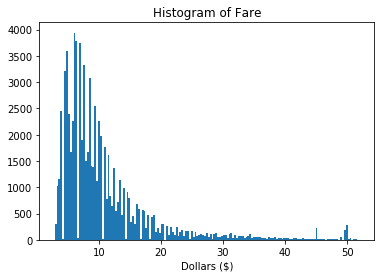

In [9]:
# minimum fare = $2.5: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

display(df_train['fare_amount'].describe(percentiles=[.01, .05, .1, .90,.95,.99]))
df_train = df_train.loc[(df_train['fare_amount'] > 2.5) & (df_train['fare_amount'] < 52)]

plt.hist(df_train['fare_amount'], bins='auto')
plt.title('Histogram of Fare')
plt.xlabel('Dollars ($)');
# display(df_train['fare_amount'].hist(bins='auto'));


## Average demand per region over 1 weekday - H3

In [10]:
# Caio's code. ~70.000 training data points makes it sparse

df_train['weekday'] = df_train['pickup_datetime'].dt.dayofweek

df_train['is_weekend'] = np.nan
df_train.loc[df_train['weekday'].isin([5,6]), 'is_weekend'] = 1
df_train.loc[np.isnan(df_train['is_weekend']), 'is_weekend'] = 0

df_train['date']  = df_train['pickup_datetime'].dt.strftime('%Y-%m-%d')
df_train['hour'] = df_train['pickup_datetime'].dt.strftime('%H:00:00')

agg_1 = df_train.groupby(['date', 'is_weekend', 'hour']).size().reset_index().rename(columns={0:'count'})
agg_2 = agg_1.groupby(['is_weekend', 'hour']).mean().reset_index().rename(columns={0:'count'})
# agg_2['count'].describe()

In [11]:
# TODO: understand and refine this step (Eva)

In [12]:
def average_demand_weekday(df,
                           pickup_latitude='pickup_latitude', pickup_longitude='pickup_longitude',
                           dropoff_latitude='dropoff_latitude', dropoff_longitude='dropoff_longitude',
                           pickup_datetime='pickup_datetime', resolution=H3_RES_ANALYSIS):
    df = df.copy()
    
    # hexagon indices
    df['pickup_h3'] = [h3.geo_to_h3(lat, long, res=resolution) for lat, long in zip(df[pickup_latitude], 
                                                                                    df[pickup_longitude])]
    df['dropoff_h3'] = [h3.geo_to_h3(lat, long, res=resolution) for lat, long in zip(df[dropoff_latitude], 
                                                                                    df[dropoff_longitude])]
    # weekday
    df['is_weekend'] = df[pickup_datetime].dt.dayofweek
    
    # aggregate per hexagon and weekday 
    df_aggregated = df.groupby(['pickup_h3','weekday']).size().reset_index(name='counts')
    
    df_demand = df.merge(df_aggregated, how = 'inner', on = ['pickup_h3', 'weekday'])
    return df_demand

df_hex = average_demand_weekday(df_train, resolution=H3_RES_ANALYSIS)

df_hex.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,weekday,is_weekend,date,hour,pickup_h3,dropoff_h3,counts
0,2015-04-05 14:04:06,-73.97853,40.764107,-73.976875,40.751816,1,10.5,6,6,2015-04-05,14:00:00,872a100d6ffffff,872a100d6ffffff,1986
1,2014-11-30 01:35:00,-73.96109,40.759340,-73.979660,40.739180,1,9.0,6,6,2014-11-30,01:00:00,872a100d6ffffff,872a100d2ffffff,1986
2,2014-03-09 16:05:00,-73.98131,40.759434,-73.988625,40.746037,1,7.5,6,6,2014-03-09,16:00:00,872a100d6ffffff,872a100d2ffffff,1986
3,2011-12-18 09:59:00,-73.97392,40.750492,-73.973000,40.753740,5,3.3,6,6,2011-12-18,09:00:00,872a100d6ffffff,872a100d6ffffff,1986
4,2015-01-11 19:08:40,-73.97714,40.758244,-73.998040,40.717827,2,15.0,6,6,2015-01-11,19:00:00,872a100d6ffffff,872a1072cffffff,1986


In the following cell you can play a little bit with hexagons.
Ideas to do:

Open the menu >
Toggle the views of the already loaded visualisations
Create a new H3 layer and choose as the hex_id either pickup_h3 or dropoff_h3
Set the color to count
Right next to the layer tool is the filter tool where you can add a filter with the weekday
More ideas:

Check other visualisations (arc, hexbin, ...)

In [13]:
# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df_hex, name='hexagons')
# w1

## Average Origin-Destination map over 1 weekday - H3

To see which routes are the most demanded, we connect the pickup hexagon centers with the dropoff hexagon centers. Can you guess the most popular drop-off?

In [14]:
def average_arc_weekday(df,
                        pickup_hex='pickup_h3', dropoff_hex='dropoff_h3',
                        counts='counts', weekday='weekday'):
    
    center_pickup_hex = 'center_pickup_hex'
    center_dropoff_hex = 'center_dropoff_hex'
    df[center_pickup_hex] = df[pickup_hex].apply(lambda x: h3.h3_to_geo(x))
    df[center_dropoff_hex] = df[dropoff_hex].apply(lambda x: h3.h3_to_geo(x))
    
    df['lng_pickup'] = df[center_pickup_hex].apply(lambda x: x[1])
    df['lat_pickup'] = df[center_pickup_hex].apply(lambda x: x[0])
    df['lng_dropoff'] = df[center_dropoff_hex].apply(lambda x: x[1])
    df['lat_dropoff'] = df[center_dropoff_hex].apply(lambda x: x[0])
    return df[['lat_pickup', 'lng_pickup', 'lat_dropoff', 'lng_dropoff', counts, weekday]].drop_duplicates()

df_arc = average_arc_weekday(df_hex)
df_arc.head()

,lat_pickup,lng_pickup,lat_dropoff,lng_dropoff,counts,weekday
0,40.760835,-73.973311,40.760835,-73.973311,1986,6
1,40.760835,-73.973311,40.741943,-73.987555,1986,6
4,40.760835,-73.973311,40.723054,-74.001787,1986,6
6,40.760835,-73.973311,40.778923,-73.989006,1986,6
12,40.760835,-73.973311,40.798625,-73.944790,1986,6


In [15]:
# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df_arc.drop_duplicates(), name='hexagons')
# w1

# Feature Engineering - Model Iterations

Now that we have a cleaner training set, we can use it to create our predictions! For teaching purposes, we're going to create multiple models, with incremental set of features/complexity. For each iteration, we're going to show a demo with the feature's concept, create a pipeline, train our models and then show and store the errors by their's [Root Mean Squared Error - RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

## Start experiment tracking

We're going to store the RMSEs for each iteration in this dictionary and look at it at the end of each iteration.

In [16]:
iteration_results = OrderedDict()

## Model 0 - Lazy Estimator - Median Fare

In order to have a baseline, we're going to start with a lazy model, one that, for every row in our training (and testing) dataset, will predict only the median fare of the training set. The only purpose of this is to have a upper error limit and we hope to see it decreasing after every iteration on the model's features.

In [17]:
median_f = df_train['fare_amount'].median()
print(f'Median Fare: {median_f}')

y_test_pred_lazy = [median_f] * df_test.shape[0]                      # array with same length as y_test

rmse = np.sqrt(mean_squared_error(df_test[TARGET], y_test_pred_lazy)) # RMSE
iteration_results['exp_0_lazy_rmse'] = rmse                             # store in experiments results
print(f'RMSE: {rmse}')

Median Fare: 8.5
RMSE: 9.61393775520487


## Model 1 - Euclidean Distance

In [18]:
## Small Example
##
def euclidean_distance(x1, y1, x2, y2):
    return (((x2-x1)**2 + (y2-y1)**2)**(1/2))

df_train_temp = df_train.head(3).copy()
df_train_temp['euclidean_dist'] = euclidean_distance(df_train_temp['pickup_latitude'], df_train_temp['pickup_longitude'], 
                                                   df_train_temp['dropoff_latitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,weekday,is_weekend,date,hour,euclidean_dist
81127,2015-04-05 14:04:06,-73.978530,40.764107,-73.976875,40.751816,1,10.5,6,1.0,2015-04-05,14:00:00,0.012402
88083,2009-10-22 20:28:40,-73.951350,40.778564,-73.963455,40.761920,2,5.7,3,0.0,2009-10-22,20:00:00,0.020580
40667,2013-09-24 11:22:00,-74.012955,40.709984,-73.989600,40.702730,1,13.0,1,0.0,2013-09-24,11:00:00,0.024456


In [19]:
def standardize_features(df):
    df_copy = df.copy()
    col_names = df_copy.columns
    ixs = df_copy.index
    return pd.DataFrame(StandardScaler().fit_transform(df_copy), columns=col_names, index=ixs)

def feature_pipeline_1(df, target_col=TARGET,
                              pickup_latitude='pickup_latitude', pickup_longitude='pickup_longitude',
                              dropoff_latitude='dropoff_latitude', dropoff_longitude='dropoff_longitude'):
  
    EUCLIDEAN_FEAT = 'euclidean_dist'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(x1=df_copy[pickup_latitude], y1=df_copy[pickup_longitude], 
                                                 x2=df_copy[dropoff_latitude], y2=df_copy[dropoff_longitude])
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()
        
    return df_copy[FEATURES + [target_col]]

df_train_1 = feature_pipeline_1(df_train)
df_test_1 = feature_pipeline_1(df_test)

df_train_1.head()

,euclidean_dist,fare_amount
81127,0.012402,10.5
88083,0.020580,5.7
40667,0.024456,13.0
69985,0.063155,20.0
22252,0.024139,6.5


In [20]:
model_1 = LinearRegression()
model_1.fit(df_train_1.drop(TARGET, axis=1), df_train_1[TARGET])

y_test_pred_1 = model_1.predict(df_test_1.drop(TARGET, axis=1))

RMSE: 4.33833106609023


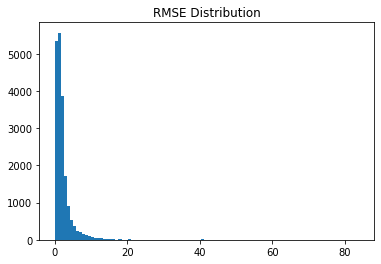

In [21]:
def print_evaluation(y_obs, y_pred, max_lim_y=100, return_errors=True):
    rmse_hist = np.sqrt((y_pred - y_obs)**2)
    plt.hist(rmse_hist[y_obs < max_lim_y], bins=100)
    plt.title('RMSE Distribution');

    if(return_errors == True):
        return mae_hist

#####
rmse = np.sqrt(mean_squared_error(df_test_1[TARGET], y_test_pred_1))
iteration_results['exp_1_rmse'] = rmse
print(f'RMSE: {rmse}')

print_evaluation(df_test_1[TARGET], y_test_pred_1, return_errors=False)

## Why the feature value above is not correct? 

Although it works for our model, if you look at pipeline1's output, the euclidean distance values don't make any sense. The linear model manages to compensate the non sense values to the output by adjusting it's weights. However, if we need to explain our model's decision, it's good to have the features into some unit of measure, whether spacial or standardized, for example. Which makes us wonder, so then, `What is Latitude/Longitude?`

### Latitude/Longitude

### Projections

### Universal Transverse Mercator (UTM) 

<img src="images/utm_grid.jpg" width="500"> 
<center>UTM Projection grid - <a href="https://www.youtube.com/watch?v=LcVlx4Gur7I">https://www.youtube.com/watch?v=LcVlx4Gur7I</a></center> 

UTM is a projection that, as other projection types, maps the spherical earth to a flat surface. However, UTM performs this operation to a set of subgrids. 
* This has the advantage of not having long distortions in the poles or in the equator, such as Mercator's or Robinson's projections. **When calculating distances from the same sub grid** 
* Suffer the same distortion effects when projecting features that encompass multiple grids or distances from far away objects  

Therefore, for localized distances between elements, *i.e.*, elements that fall over the same grid, [UTM is a good projection system](https://www.esri.com/arcgis-blog/products/arcgis-enterprise/mapping/measuring-distances-and-areas-when-your-map-uses-the-mercator-projection/). In our distance calculations, UTM is a good choice, because their projections are calculated on `meters` unit.
  
UTM projects the latitude and longitude to a [three numbers representation][https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#Locating_a_position_using_UTM_coordinates]:
* **Zone** - Zone is a number attributed to every grid as in the picture above. We can use online tools to figure out the UTM zone of a region
* **Easting** - For every grid, their central meridian starts with a value of 500.000 and the *easting* value represents how many `meters` east is the point to this grid's meridian
* **Northing** - For every grid, this value represents how far away the point is from the south pole `in meters`

### Adapted Pipeline 1 code for UTM

To project our lat/lon points to UTM, we use the [pyproj](https://pypi.org/project/pyproj/#description) package. **Notice** how, in the function, we have to send the coordinates in the correct order - **longitude**/**latitude**:

In [22]:
## Small Example
##
def latlon2UTM(latitudes, longitudes, utm_proj_zone=18):
    # project points to UTM
    # New York city zone = 18 - https://www.latlong.net/lat-long-utm.html
    lonlat2UTM = Proj(proj='utm', zone=utm_proj_zone, ellps='WGS84') 
    point_easting, point_northing = lonlat2UTM(longitudes, latitudes)
    # lonlat2UTM(point_easting,point_northing,inverse=True) # to convert UTM back to lon/lat
    return point_easting, point_northing

df_train_temp = df_train.head(3).copy()

pickup_dropoff_cols = ['pickup', 'dropoff']
for point in pickup_dropoff_cols:
    point_easting, point_northing = latlon2UTM(latitudes=df_train_temp[f'{point}_latitude'].values,
                                               longitudes=df_train_temp[f'{point}_longitude'].values)
    df_train_temp[f'{point}_easting'] = point_easting
    df_train_temp[f'{point}_northing'] = point_northing
    
df_train_temp    

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,weekday,is_weekend,date,hour,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing
81127,2015-04-05 14:04:06,-73.978530,40.764107,-73.976875,40.751816,1,10.5,6,1.0,2015-04-05,14:00:00,586213.422929,4.513073e+06,586369.017332,4.511710e+06
88083,2009-10-22 20:28:40,-73.951350,40.778564,-73.963455,40.761920,2,5.7,3,0.0,2009-10-22,20:00:00,588488.305192,4.514705e+06,587488.661543,4.512845e+06
40667,2013-09-24 11:22:00,-74.012955,40.709984,-73.989600,40.702730,1,13.0,1,0.0,2013-09-24,11:00:00,583375.414083,4.507032e+06,585357.497098,4.506249e+06


In [23]:
def feature_pipeline_1b(df, target_col=TARGET,
                       pickup_latitude='pickup_latitude', pickup_longitude='pickup_longitude',
                       dropoff_latitude='dropoff_latitude', dropoff_longitude='dropoff_longitude',
                       utm_proj_zone=18):
  
    EUCLIDEAN_FEAT = 'euclidean_dist_km'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    
    pickup_dropoff_cols = ['pickup', 'dropoff']
    for point in pickup_dropoff_cols:
        point_easting, point_northing = latlon2UTM(latitudes=df_copy[f'{point}_latitude'].values,
                                                   longitudes=df_copy[f'{point}_longitude'].values)
        df_copy[f'{point}_easting'] = point_easting
        df_copy[f'{point}_northing'] = point_northing
    
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()
        
    return df_copy[FEATURES + [target_col]]

df_train_1b = feature_pipeline_1b(df_train)
df_test_1b = feature_pipeline_1b(df_test)

df_train_1b.head()


,euclidean_dist_km,fare_amount
81127,1.371619,10.5
88083,2.111392,5.7
40667,2.131066,13.0
69985,6.568325,20.0
22252,2.446133,6.5


In [24]:
model_1b = LinearRegression()
model_1b.fit(df_train_1b.drop(TARGET, axis=1), df_train_1b[TARGET])

y_test_pred_1b = model_1b.predict(df_test_1b.drop(TARGET, axis=1))

RMSE: 4.464849428041979


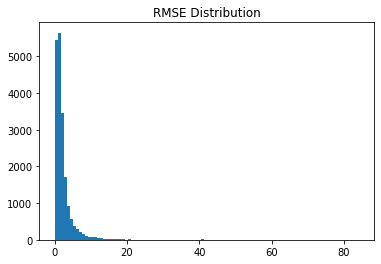

In [25]:
rmse = np.sqrt(mean_squared_error(df_test_1b[TARGET], y_test_pred_1b))
iteration_results['exp_1b_rmse'] = rmse
print(f'RMSE: {rmse}')

print_evaluation(df_test_1b[TARGET], y_test_pred_1b, return_errors=False)

We can see that the score didn't change much, for small distances there's a big chance that latitude/longitude are highly correlated to UTM projections, except for the unit, which in UTM refers to meters, while lat/lon distances doesn't have any real unit.

In [29]:
df_train_1[['euclidean_dist']].merge(df_train_1b[['euclidean_dist_km']], left_index=True, right_index=True).corr()

,euclidean_dist,euclidean_dist_km
euclidean_dist,1.000000,0.992296
euclidean_dist_km,0.992296,1.000000


### Manhattan - TODO: Explain

### Haversine Distance:

Both euclidean and manhattan are calculated considering that point P and Q are in a plane like a square. However, depending on the distance between the two points, these distances don't take the curvature of the earth into consideration, and their values would measure a distance that would cross through the earth!
  
<img src="images/haversine_example.png" width="250"> 
<center>Blue line representing euclidean distance between two further points P and Q and Haversine distance in red. Adapted from <a href="https://en.wikipedia.org/wiki/Great-circle_distance">Wikipedia</a></center>  

To account for this curvature, we use the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). It originally works with latitudes and longitudes so we don't even need to project our points to UTM before hand.  
  
As in this workshop we're dealing with small enough distances considering the whole earth as parameter, we don't expect big differences between the euclidean and Haversine. However, if you're dealing with bigger distances, Haversine should be preferred.

In [30]:
## Small Example
##
def manhattan_distance(x1, y1, x2, y2):        
    dy = np.abs(y2 - y1)
    dx = np.abs(x2 - x1)
    return dy + dx

def lat_longs2radians(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    return lat1, lon1, lat2, lon2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lat1, lon1, lat2, lon2 = lat_longs2radians(lat1, lon1, lat2, lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


#####
#####
df_train_temp = df_train.head(3).copy()
df_train_temp['haversine_dist'] = haversine_distance(df_train_temp['pickup_latitude'], df_train_temp['pickup_longitude'], 
                                                     df_train_temp['dropoff_latitude'], df_train_temp['dropoff_longitude'])

pickup_dropoff_cols = ['pickup', 'dropoff']
for point in pickup_dropoff_cols:
    point_easting, point_northing = latlon2UTM(latitudes=df_train_temp[f'{point}_latitude'].values,
                                               longitudes=df_train_temp[f'{point}_longitude'].values)
    df_train_temp[f'{point}_easting'] = point_easting
    df_train_temp[f'{point}_northing'] = point_northing
df_train_temp['manhattan_dist'] = manhattan_distance(df_train_temp['pickup_northing'], df_train_temp['pickup_easting'], 
                                                     df_train_temp['dropoff_northing'], df_train_temp['dropoff_easting'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,weekday,is_weekend,date,hour,haversine_dist,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing,manhattan_dist
81127,2015-04-05 14:04:06,-73.978530,40.764107,-73.976875,40.751816,1,10.5,6,1.0,2015-04-05,14:00:00,1.372925,586213.422929,4.513073e+06,586369.017332,4.511710e+06,1518.359572
88083,2009-10-22 20:28:40,-73.951350,40.778564,-73.963455,40.761920,2,5.7,3,0.0,2009-10-22,20:00:00,2.111571,588488.305192,4.514705e+06,587488.661543,4.512845e+06,2859.398369
40667,2013-09-24 11:22:00,-74.012955,40.709984,-73.989600,40.702730,1,13.0,1,0.0,2013-09-24,11:00:00,2.126155,583375.414083,4.507032e+06,585357.497098,4.506249e+06,2764.892328


In [31]:
def feature_pipeline_2(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
    EUCLIDEAN_FEAT = 'euclidean_dist_km'
    HAVERSINE_FEAT = 'haversine_dist_km'
    MANHATTAN_FEAT = 'manhattan_dist_km'
    FEATURES = [EUCLIDEAN_FEAT, MANHATTAN_FEAT, HAVERSINE_FEAT]

    df_copy = df.copy()
    
    pickup_dropoff_cols = ['pickup', 'dropoff']
    for point in pickup_dropoff_cols:
        point_easting, point_northing = latlon2UTM(latitudes=df_copy[f'{point}_latitude'].values,
                                                   longitudes=df_copy[f'{point}_longitude'].values)
        df_copy[f'{point}_easting'] = point_easting
        df_copy[f'{point}_northing'] = point_northing

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[MANHATTAN_FEAT] = manhattan_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[HAVERSINE_FEAT] = haversine_distance(lat1=df_copy[pickup_latitude], lon1=df_copy[pickup_longitude], 
                                                 lat2=df_copy[dropoff_latitude], lon2=df_copy[dropoff_longitude])

    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()
    
    return df_copy[FEATURES + [target_col]]

df_train_2 = feature_pipeline_2(df_train)
df_test_2 = feature_pipeline_2(df_test)

df_train_2.head()

,euclidean_dist_km,manhattan_dist_km,haversine_dist_km,fare_amount
81127,1.371619,1.518360,1.372925,10.5
88083,2.111392,2.859398,2.111571,5.7
40667,2.131066,2.764892,2.126155,13.0
69985,6.568325,8.744601,6.570039,20.0
22252,2.446133,3.355554,2.445977,6.5


In [32]:
model_2 = LinearRegression()
model_2.fit(df_train_2.drop(TARGET, axis=1), df_train_2[TARGET])

y_test_pred_2 = model_2.predict(df_test_2.drop(TARGET, axis=1))

RMSE Error: 4.308687683809414


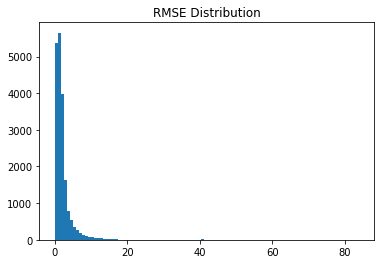

In [33]:
rmse_2 = np.sqrt(mean_squared_error(df_test_2[TARGET], y_test_pred_2))
iteration_results['exp_2_rmse'] = rmse_2
print(f'RMSE Error: {rmse_2}')

print_evaluation(df_test_2[TARGET], y_test_pred_2, return_errors=False)

In [34]:
iteration_results

OrderedDict([('exp_0_lazy_rmse', 9.61393775520487),
             ('exp_1_rmse', 4.33833106609023),
             ('exp_1b_rmse', 4.464849428041979),
             ('exp_2_rmse', 4.308687683809414)])

## Using fastest route distance and duration - OSRM

<img src="images/route_distance_.png" width="350"> 
<center>Blue line representing straight line distance between points A and B while real route distance is displayed by Google Maps. Source: <a href="https://shorturl.at/cqz37">Google Maps</a></center>  

All the distances seen by now are straight line distances, *i.e.* the minimal distance that connects the two points. However, in a city, we can only walk, drive or cycle through streets and sidewalks. Take a look at the picture above. Even though the origin and destination are in a certain distance, we can't go through the river with our cars (theoretically). Routers such as google maps have the city street layout with them and so they can calculate routes by different means of transportation. A open source tool works over [Open Street Maps](https://www.openstreetmap.org/about) (OSM) and can calculate these routes for us. For testing their API, they make a [demo](https://map.project-osrm.org/) and a [public server](https://github.com/Project-OSRM/osrm-backend/wiki/Demo-server) available, but in both you're limited to a limited amount of requests, in order not to overload them.  
  
If we want to freely use the router's features, we can deploy one OSRM's instance in our machine or in your own servers. Next, we're going to see how we do it.  

## Setup  

We can setup OSRM by two ways:
* Use a standard pre-created dockerfile - [Source](https://hub.docker.com/r/osrm/osrm-backend/)
* Compile from source - [Source](https://github.com/Project-OSRM/osrm-backend#building-from-source)

OSRM works with many configuration files, such as transportation profiles, which configure streets max speeds and allowed paths. The standard configuration works really well for almost all simple cases and the dockerfiles are way simpler to set up. However, if you want to adapt any of these files, you'd have to download and compile the source code with the custom preferences changed. Here, we're going to see how to set up using dockerfiles:

While setting up this workshop project (with `make`) we've already set up a functional OSRM for you and you can go to next cells to test it out :)  
However, for the learning process, we can do it locally with the instructions below, which, by the way, are the same commands that the `makefile` is doing in `make setup`.  

Instructions:   

<div class="alert alert-block alert-info">     
    
* Open a terminal and go to your project folder, create a <i>router</i> folder for cleanliness

* wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf (file is ~200 Mb)

* In the terminal, move to the folder where the file above was put and execute the following commands:

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf  
     
</div>    

Now you have the router running in a dedicated process. In order to test it, open another tab in the terminal and type the following:  

Test: `curl "http://localhost:5000/route/v1/driving/-73.996070,40.732605;-73.980675,40.761864?steps=false&geometries=geojson&annotations=true&overview=full"`  
 
This is a command to make a route between the two provided lon/lats. You can check more options at the [API documentation](http://project-osrm.org/docs/v5.5.1/api/#route-service)

## Calculate street distances and durations  

For our pipelines, we're going to use the custom class `utils.OSRMFramework.OSRMFramework` to request and retrieve route data from a OSRM instance. When building the class, you have to send the instance's URL. When it's set up locally with docker, the address is `localhost:5000`. After it, you can use `OSRMFramework.route` sending the pick-up and dropoff's latitudes and longitudes and obtain back 5 types of data:  
1 - and 2. - Latitude and longitudes that compose the route   
3 - Estimated route distance  
4 - Estimated route duration  
5 - OSM Node ids. These will be explained in the [Traffic Prototype](#Traffic-Prototype) section.  

In [164]:
## Small Example
##
lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

osm = OSRMFramework('localhost:5000')
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

In [36]:
## Small Example
##
def get_route(osm, lat1, lon1, lat2, lon2):
    lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)
    return_col_names = ['route', 'distance_m', 'duration_sec', 'node_ids']
    if(type(lat) == float):
        return pd.Series([np.nan] * len(return_col_names), index=return_col_names)
    else:
        return pd.Series([latlon2linestring(lat, lon), distance, duration, node_ids], index=return_col_names)

routes = df_train.head().apply(lambda row: get_route(osm, 
                                            row['pickup_latitude'],
                                            row['pickup_longitude'],
                                            row['dropoff_latitude'],
                                            row['dropoff_longitude']), axis=1)
routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)

routes

,route,distance_m,duration_sec,node_ids
81127,"LINESTRING (-73.97853000000001 40.764107, -73....",2235.5,207.0,"[4544486781, 42430378, 42430384, 6654368342, 4..."
88083,"LINESTRING (-73.95135000000001 40.778564, -73....",2849.2,300.7,"[42443040, 42450030, 42447136, 42429334, 54025..."
40667,LINESTRING (-74.01295500000001 40.709984000000...,3532.1,392.5,"[42434413, 5487737822, 42436192, 1506902240, 4..."
69985,"LINESTRING (-73.97279 40.758907, -73.972846 40...",8963.1,694.2,"[3977886228, 596775914, 596775876, 3977886201,..."
22252,"LINESTRING (-73.98543000000001 40.740368, -73....",2935.9,327.5,"[42436578, 42436582, 4115878741, 42436586, 411..."


In [37]:
# TEMP: because router take too much time, I've saved the routes from this sample here. If you want to
# use the router anyway, comment lines where pickle is read and uncomment commented lines

# TEMP files are saved on GDrive for now: 
# https://drive.google.com/file/d/1wQI18n982C0QmeH2iJWVxQbxoHuddktM/view?usp=sharing

def feature_pipeline_3(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              osm_router=OSRM_PATH,
                              test_mode=None):
    EUCLIDEAN_FEAT = 'euclidean_dist_km'
    HAVERSINE_FEAT = 'haversine_dist_km'
    MANHATTAN_FEAT = 'manhattan_dist_km'
    ROUTE_DISTANCE = 'route_distance_km'
    ROUTE_DURATION = 'route_duration_min'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                MANHATTAN_FEAT, 
                HAVERSINE_FEAT,
                ROUTE_DISTANCE,
                ROUTE_DURATION] 

    df_copy = df.copy()

    pickup_dropoff_cols = ['pickup', 'dropoff']
    for point in pickup_dropoff_cols:
        point_easting, point_northing = latlon2UTM(latitudes=df_copy[f'{point}_latitude'].values,
                                                   longitudes=df_copy[f'{point}_longitude'].values)
        df_copy[f'{point}_easting'] = point_easting
        df_copy[f'{point}_northing'] = point_northing

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[MANHATTAN_FEAT] = manhattan_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[HAVERSINE_FEAT] = haversine_distance(lat1=df_copy[pickup_latitude], lon1=df_copy[pickup_longitude], 
                                                 lat2=df_copy[dropoff_latitude], lon2=df_copy[dropoff_longitude])
    
    if(test_mode == 'train'):                                                          # TEST MODE
        with open('data/temp_routes_train.pickle', 'rb') as f:                         # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE
    elif(test_mode == 'test'):                                                         # TEST MODE
        with open('data/temp_routes_test.pickle', 'rb') as f:                          # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE   
        
#     routes = df_copy.apply(lambda row: get_route(osm, 
#                                             row['pickup_latitude'],
#                                             row['pickup_longitude'],
#                                             row['dropoff_latitude'],
#                                             row['dropoff_longitude']), axis=1)
#     routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']/1000
    df_copy[ROUTE_DURATION] = routes['duration_sec']/60
    
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    
    return df_copy[FEATURES + [target_col]], routes

df_train_3, routes_train = feature_pipeline_3(df_train, test_mode='train')
df_test_3, routes_test = feature_pipeline_3(df_test, test_mode='test')

df_train_3.head()

##### Save locally when executting OSRM --> REMOVE THIS SECTION WHEN NOTEBOOK IS READY FOR WORKSHOP
# with open('data/temp_routes_train.pickle', 'wb') as f:
#     pickle.dump(routes_train, f)
    
# with open('data/temp_routes_test.pickle', 'wb') as f:
#     pickle.dump(routes_test, f)

,euclidean_dist_km,manhattan_dist_km,haversine_dist_km,route_distance_km,route_duration_min,fare_amount
81127,1.371619,1.518360,1.372925,2.2355,3.450000,10.5
88083,2.111392,2.859398,2.111571,2.8492,5.011667,5.7
40667,2.131066,2.764892,2.126155,3.5321,6.650000,13.0
69985,6.568325,8.744601,6.570039,8.9631,11.570000,20.0
22252,2.446133,3.355554,2.445977,2.9359,5.458333,6.5


In [38]:
model_3 = LinearRegression()
model_3.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
y_test_pred_3 = model_3.predict(df_test_3.drop(TARGET, axis=1))


RMSE Error: 4.19733414510375


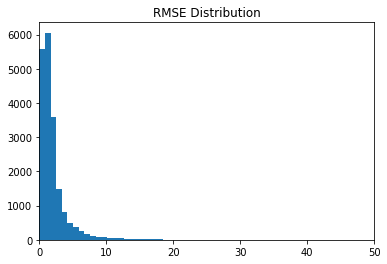

In [39]:
#####
rmse_3 = np.sqrt(mean_squared_error(df_test_3[TARGET], y_test_pred_3))
iteration_results['exp_3_osrm'] = rmse_3
print(f'RMSE Error: {rmse_3}')

print_evaluation(df_test_3[TARGET], y_test_pred_3, return_errors=False)
plt.xlim([0, 50]);

In [40]:
iteration_results

OrderedDict([('exp_0_lazy_rmse', 9.61393775520487),
             ('exp_1_rmse', 4.33833106609023),
             ('exp_1b_rmse', 4.464849428041979),
             ('exp_2_rmse', 4.308687683809414),
             ('exp_3_osrm', 4.19733414510375)])

## 2nd Exploratory Analysis

### Check why we have some route distance == 0

In [41]:
df_train_3_analysis = df_train_3.merge(df_train, how='left', left_index=True, right_index=True)

df_train_3_analysis['route_distance_km'] = routes_train['distance_m']/1000
display(df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head()) # PROBLEM pickup == dropoff

##########################################################
### Filter where pick up and drop off are the same
##########################################################


,euclidean_dist_km,manhattan_dist_km,haversine_dist_km,route_distance_km,route_duration_min,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,weekday,is_weekend,date,hour
59542,0.000000,0.000000,0.000000,0.0,0.0,5.0,2013-06-04 10:05:50,-73.901955,40.76404,-73.901955,40.76404,1,5.0,1,0.0,2013-06-04,10:00:00
38815,0.000000,0.000000,0.000000,0.0,0.0,7.5,2012-10-26 22:26:00,-73.989100,40.73636,-73.989100,40.73636,1,7.5,4,0.0,2012-10-26,22:00:00
51352,0.000000,0.000000,0.000000,0.0,0.0,27.3,2012-03-30 12:01:00,-73.937454,40.75812,-73.937454,40.75812,1,27.3,4,0.0,2012-03-30,12:00:00
68537,0.000000,0.000000,0.000000,0.0,0.0,9.3,2011-10-27 20:01:19,-73.870820,40.78310,-73.870820,40.78310,1,9.3,3,0.0,2011-10-27,20:00:00
75880,0.510611,0.581354,0.511076,0.0,0.0,45.0,2014-11-22 01:06:00,-74.061500,40.73936,-74.060530,40.74390,1,45.0,5,1.0,2014-11-22,01:00:00


### Some leftover routes still have route_distance == 0, investigate

In [42]:
df_train_3_analysis = df_train_3_analysis.loc[df_train.index].copy()

df_train_3_analysis['distances'] = haversine_distance(df_train_3_analysis['pickup_latitude'], df_train_3_analysis['dropoff_latitude'],
                               df_train_3_analysis['pickup_longitude'], df_train_3_analysis['dropoff_longitude'])

df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head() ### ?? - ~65 examples

##########################################################
### Filter where route_distance == 0 for next iteration###
##########################################################


,euclidean_dist_km,manhattan_dist_km,haversine_dist_km,route_distance_km,route_duration_min,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,weekday,is_weekend,date,hour,distances
59542,0.000000,0.000000,0.000000,0.0,0.0,5.0,2013-06-04 10:05:50,-73.901955,40.76404,-73.901955,40.76404,1,5.0,1,0.0,2013-06-04,10:00:00,15073.251527
38815,0.000000,0.000000,0.000000,0.0,0.0,7.5,2012-10-26 22:26:00,-73.989100,40.73636,-73.989100,40.73636,1,7.5,4,0.0,2012-10-26,22:00:00,15070.467427
51352,0.000000,0.000000,0.000000,0.0,0.0,27.3,2012-03-30 12:01:00,-73.937454,40.75812,-73.937454,40.75812,1,27.3,4,0.0,2012-03-30,12:00:00,15072.839668
68537,0.000000,0.000000,0.000000,0.0,0.0,9.3,2011-10-27 20:01:19,-73.870820,40.78310,-73.870820,40.78310,1,9.3,3,0.0,2011-10-27,20:00:00,15075.465545
75880,0.510611,0.581354,0.511076,0.0,0.0,45.0,2014-11-22 01:06:00,-74.061500,40.73936,-74.060530,40.74390,1,45.0,5,1.0,2014-11-22,01:00:00,15071.710550


### Check price per kilometer

In [43]:
temp = df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] != 0]

price_km = temp['fare_amount_y']/temp['route_distance_km']
display(price_km.describe(percentiles=[.9, .95, .99]))

##########################################################
### Filter where price per km > 5 - 95th percentile    ###
##########################################################

count     76317.000000
mean         58.028857
std        4080.245475
min           0.165007
50%           2.854109
90%           4.810838
95%           5.858411
99%          11.065728
max      498000.000000
dtype: float64

## Embed taxi rules - https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

In [44]:
# TODO: Investigate

## Embed Nearest neighboors fares

1st Geography Law: https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography

"everything is related to everything else, but near things are more related than distant things."

In [45]:
# TODO: Show small example as previous pipelines
## Small Example
##

In [46]:
def feature_pipeline_4(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              pickup_datetime_col='pickup_datetime',
                              osm_router=OSRM_PATH,
                              nn_avg_fare_model=None,
                              test_mode=None):
    EUCLIDEAN_FEAT = 'euclidean_dist_km'
    HAVERSINE_FEAT = 'haversine_dist_km'
    MANHATTAN_FEAT = 'manhattan_dist_km'
    ROUTE_DISTANCE = 'route_distance_km'
    ROUTE_DURATION = 'route_duration_min'
    NN_AVG_FARE = 'nn_avg_fare'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                MANHATTAN_FEAT,
                HAVERSINE_FEAT,
                ROUTE_DISTANCE,
                ROUTE_DURATION,
                NN_AVG_FARE] 

    df_copy = df.copy()

    pickup_dropoff_cols = ['pickup', 'dropoff']
    for point in pickup_dropoff_cols:
        point_easting, point_northing = latlon2UTM(latitudes=df_copy[f'{point}_latitude'].values,
                                                   longitudes=df_copy[f'{point}_longitude'].values)
        df_copy[f'{point}_easting'] = point_easting
        df_copy[f'{point}_northing'] = point_northing

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[MANHATTAN_FEAT] = manhattan_distance(x1=df_copy['pickup_northing'], y1=df_copy['pickup_easting'], 
                                                 x2=df_copy['dropoff_northing'], y2=df_copy['dropoff_easting'])/1000
    df_copy[HAVERSINE_FEAT] = haversine_distance(lat1=df_copy[pickup_latitude], lon1=df_copy[pickup_longitude], 
                                                 lat2=df_copy[dropoff_latitude], lon2=df_copy[dropoff_longitude])
    
    if(test_mode == 'train'):                                                          # TEST MODE
        with open('data/temp_routes_train.pickle', 'rb') as f:                         # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE
    elif(test_mode == 'test'):                                                         # TEST MODE
        with open('data/temp_routes_test.pickle', 'rb') as f:                          # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE   
        
#     routes = df_copy.apply(lambda row: get_route(osm, 
#                                             row['pickup_latitude'],
#                                             row['pickup_longitude'],
#                                             row['dropoff_latitude'],
#                                             row['dropoff_longitude']), axis=1)

#     routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']
    df_copy[ROUTE_DURATION] = routes['duration_sec']
    
    ###### Outliers Filtering
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()
    
    df_copy = df_copy.loc[df_copy[ROUTE_DISTANCE] != 0].copy()
    
    price_per_km = df_copy[target_col]/(df_copy[ROUTE_DISTANCE]/1000)
    df_copy = df_copy.loc[price_per_km < 5].copy()
    ######
    
    ###### prepare for NN avg fare model
    minutes_since_monday_midnight = 'minutes_since_monday_midnight'
    df_copy[minutes_since_monday_midnight] = df_copy[pickup_datetime_col].dt.dayofweek * (24*60) + \
                                               df_copy[pickup_datetime_col].dt.hour * 60 + \
                                               df_copy[pickup_datetime_col].dt.minute
    
    
    nn_features = [pickup_latitude, pickup_longitude, 
                       dropoff_latitude, dropoff_longitude, 
                       minutes_since_monday_midnight]
    nn_data = standardize_features(df_copy[nn_features])
    nn_data[target_col] = df_copy[target_col]
    if(test_mode == 'train'):
        nn_avg_fare_model = KNeighborsRegressor(n_neighbors=10)
        nn_avg_fare_model.fit(nn_data.drop(target_col, axis=1), nn_data[target_col])
    df_copy[NN_AVG_FARE] = nn_avg_fare_model.predict(nn_data.drop(target_col, axis=1))  
    ######
    
    return df_copy[FEATURES + [target_col]], routes, nn_avg_fare_model

df_train_4, routes_train, nn_avg_fare_model = feature_pipeline_4(df_train, test_mode='train')
df_test_4, routes_test, nn_avg_fare_model = feature_pipeline_4(df_test, test_mode='test', nn_avg_fare_model=nn_avg_fare_model)

df_train_4.head()


,euclidean_dist_km,manhattan_dist_km,haversine_dist_km,route_distance_km,route_duration_min,nn_avg_fare,fare_amount
81127,1.371619,1.518360,1.372925,2235.5,207.0,7.33,10.5
88083,2.111392,2.859398,2.111571,2849.2,300.7,6.66,5.7
40667,2.131066,2.764892,2.126155,3532.1,399.0,8.66,13.0
69985,6.568325,8.744601,6.570039,8963.1,694.2,17.16,20.0
22252,2.446133,3.355554,2.445977,2935.9,327.5,7.52,6.5


In [47]:
model_4 = LinearRegression()
model_4.fit(df_train_4.drop(TARGET, axis=1), df_train_4[TARGET])
y_test_pred_4 = model_4.predict(df_test_4.drop(TARGET, axis=1))


RMSE Error: 3.274720992073476


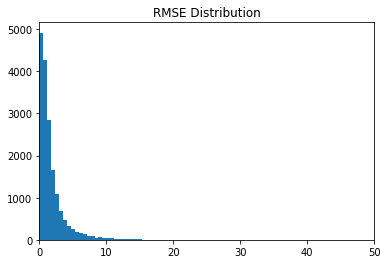

In [48]:
#####
rmse_4 = np.sqrt(mean_squared_error(df_test_4[TARGET], y_test_pred_4))
iteration_results['exp_4_knn_rmse'] = rmse_4
print(f'RMSE Error: {rmse_4}')

print_evaluation(df_test_4[TARGET], y_test_pred_4, return_errors=False)
plt.xlim([0, 50]);

In [49]:
iteration_results

OrderedDict([('exp_0_lazy_rmse', 9.61393775520487),
             ('exp_1_rmse', 4.33833106609023),
             ('exp_1b_rmse', 4.464849428041979),
             ('exp_2_rmse', 4.308687683809414),
             ('exp_3_osrm', 4.19733414510375),
             ('exp_4_rmse', 3.274720992073476)])

### How to speed up spatial queries:

<img src="images/spatial_indexes.png" width="500"> 
<center>Example of spatial indexes. Source: <a href="https://www.youtube.com/watch?v=_95bSEqMzUA">Youtube: Alexander Müller - Spatial Range Queries Using Python In-Memory Indices</a></center>  

Traditional databases have indexes in their system that makes it possible to quickly **find** an element. However, when we are working with elements that have a **spatial relationship**, these indexes don't help us to perform common operations that are frequently performed with spatial data, *i.e.*, with lines and polygons besides points:  
* Find K neighboors for every point
* Check if points are inside a table of polygons - [spatial joins](http://geopandas.org/mergingdata.html)
* Check if lines/polygons intersect and extract their joined/intersected area  

Common GIS databases, such as [PostGIS](https://postgis.net/) already have optimizations for this kind of operations. However, how can we create the same features with Python?  

**Spatial Indexes**:  
  
If you look at the [KNNRegressor's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html), you'll see that they have a parameter `algorithm` which is used to find the nearest neighbor. These algorithms, or indexes, maintain a data structure that holds information about the object's proximity. A well established python implementation of spatial index is a `R-Tree` and [Reference 1](http://toblerity.org/rtree/) and [Reference 2](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/) show a bit how do they work and could you implement for your spatial queries:  
  
<img src="images/r_tree.png" width="600"> 
<center>Insert process of a R-Tree</center>  

Imagine you have a set of geometries. We can merge these data points into 2 (or more) separated `bounding boxes` based on a specific heuristic. At the next step, you can interpret that each of the new bounding boxes are themselves a polygon. We can then apply the same heuristics to merge the polygons into higher level bounding boxes and repeat the process until we have just 1 level, the tree root, which is a bounding box that contains all other bounding boxes.  There you go, you have your R(Rectangle)-Tree!

<img src="images/r_tree_2.png" width="600"> 
<center>Built R-Tree</center>  
  
Because the way the algorithm was build, the **search** process has spatial operations embedded into its functionality. Suppose you want to find the nearest neighbors of your point (or line or polygon). In a traditional approach you would:
* Calculate the distance from the geometry A to all other geometries
* Sort in increasing order
* Choose the K closest neighbors   
 
When you have millions of points, these steps are quite heavy processing. With the R-Tree indexed dataset:   
  
* From the tree structure, find which bounding box your geometry is:
* Retrieve all geometries from inside the leaf node (or from neighbors leaf nodes bounding boxes as well)
* Calculate distances, sort and select K closest  

The R-Tree helps with filtering out the majority of the dataset that lives outside of the point's bounding box. After the big filtering is done, all the other calculations follow in the same way.   
  
[Here](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/) is an example that filter streets based on a city polygon using R-Trees.
  
Lets say we wanted to check which routes intersect with a route of interest that we manually selected. [Geopandas](http://geopandas.org/) can perform [spatial joins](https://medium.com/@bobhaffner/spatial-joins-in-geopandas-c5e916a763f3) in order to join tables [based on the relationship types between two geometry columns](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates). Here, we use the `intersects` operation in GeoPandas to check whether two linestrings intersect each other. However, the operation is unfortunately still [done element per element](https://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1). With the R-Tree, we still do element by element search, but we can firstly subselect close-by elements and then perform `intersects` with a small subset of the total dataset. With bigger datasets, this difference in approaches can lead to big differences in performance, as we can see in the example below:

In [99]:
def create_r_tree(gdf, geometry_col):
    idx = index.Index()
    #Populate R-tree index with bounds of grid cells
    for ix, cell in gdf.iterrows():
        # in GeoPandas, there's always a geometry col and it's always a shapely 
        idx.insert(ix, cell[geometry_col].bounds)
    return idx


N Samples: 7500
# intersecting routes found without index: 6
# intersecting routes found with index: 6 

N Samples: 15000
# intersecting routes found without index: 20
# intersecting routes found with index: 20 

N Samples: 22500
# intersecting routes found without index: 30
# intersecting routes found with index: 30 

N Samples: 30000
# intersecting routes found without index: 39
# intersecting routes found with index: 39 

N Samples: 37500
# intersecting routes found without index: 47
# intersecting routes found with index: 47 

N Samples: 45000
# intersecting routes found without index: 58
# intersecting routes found with index: 58 

N Samples: 52500
# intersecting routes found without index: 69
# intersecting routes found with index: 69 

N Samples: 60000
# intersecting routes found without index: 87
# intersecting routes found with index: 87 

N Samples: 67500
# intersecting routes found without index: 93
# intersecting routes found with index: 93 

N Samples: 75000
# intersecting

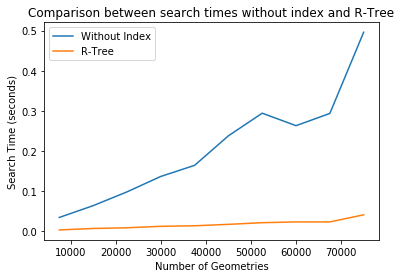

In [163]:
df_geoix = routes_train.loc[(routes_train['distance_m'] > 100) & (routes_train['distance_m'] < 500)]
df_geoix = GeoDataFrame(df_geoix, geometry='route') # convert df to GeoDf, allow methods such as 'intersects'
n_samples = np.arange(7500, 75001, 7500)            # different resample sizes (10)
times_no_geoix = []                                 # store processing time for searches with no spatial index
times_geoix = []                                    # store processing time for searches with R-Tree
intersect_line = df_geoix.loc[1584]['route']        # linstring geometry

for n_sample in n_samples:
    print(f'N Samples: {n_sample}')
    df_geoix_sample = df_geoix.sample(n_sample, replace=True, random_state=42).reset_index(drop=True)
    idx = create_r_tree(df_geoix_sample, 'route')
    
    #### without index
    time_no_geoix = time.time()
    filter_1 = df_geoix_sample.intersects(intersect_line)
    routes_ix = filter_1[filter_1 == True].index
    times_no_geoix.append(time.time() - time_no_geoix)
    print(f'* intersecting routes found without index: {len(routes_ix)}')
    
    #### with index
    # Filter possible candidates by bouding boxes
    time_with_geoix = time.time()
    idxs = list(idx.intersection(intersect_line.bounds))
    if(len(idxs) > 0):
        # Now do actual intersection
        filter_2 = df_geoix_sample.loc[idxs].intersects(intersect_line)
        routes_ix = df_geoix_sample.loc[filter_2[filter_2 == True].index]
        times_geoix.append(time.time() - time_with_geoix)
        print(f'* intersecting routes found with index: {len(routes_ix)} \n')
    
plt.plot(n_samples, times_no_geoix)
plt.plot(n_samples, times_geoix)
plt.title('Comparison between search times without index and R-Tree')
plt.xlabel('Number of Geometries')
plt.ylabel('Search Time (seconds)')
plt.legend(['Without Index', 'R-Tree']);        
    

<div class="alert alert-block alert-info">     
You might have notices the first line of code in the code block above, where I filtered for short routes. The reason I've done this is that the spatial indexes are efficient when the object you're trying to join with results in a small number of intersection with other elements. If we had selected a long street that intersected with most routes from our dataset, the index would filter almost no elements and the following search operation would be similar to the one performed by GeoPandas
</div>    

# Retrieving Extra Map Features

Before we dig into the traffic data incorporation, lets first take a look at how OSM maps data internally:  

## OSM Data Model

### Nodes, Ways and Relations  

<img src="images/osm_data_types_.jpg" width="500"> 
<center>Data types in OSM</center>  

Everything that is inside OSM is represent by one of three possible geometries ([Reference](https://labs.mapbox.com/mapping/osm-data-model/)):
* **Node** - A node is everything that can be represented by a point, a unique object with no large spatial dimensions, such as a POIs or objects, such as this lamp post: https://www.openstreetmap.org/node/6343276469  
* **Way** - A way is a line connecting two or more nodes. In this workshop's use case, ways are mainly streets connecting two nodes, *i.e.*, street intersections. Example: https://www.openstreetmap.org/way/4402228
* **Relations** - As the name says, relations are used to create higher level structures that contains nodes and ways inside it. Example: https://www.openstreetmap.org/relation/1685018  

### Tags
  
Tags are the metadata of each data type defined above. All data types contains a set of possible (but not mandatory) tags related to the tags' semantics. For instance, if you look at the left side of the screen in any of the data types examples above, you'll see that:  
* **Nodes** have a description of what exactly is the node. Implicitly, **all** OSM nodes also have a `latitude/longitude` associated with it.
* Street **Ways** have informations about the street, such as whether it has a `bicycle path`, if it has a `sidewalk` and mainly, what is it's `maximum driving speed`. An important observation on ways is that **it doesn't always have maximum speed**. Ways in OSM were not created having routing in mind so that ways can be defined split in multiple pieces or a same path can be inside different ways. See for example https://www.openstreetmap.org/way/7552152 and https://www.openstreetmap.org/way/48859717. Street ways can also be complex because we might not have the same street speed during the whole 
* An important feature about **Relations** is their [administrative level](https://wiki.openstreetmap.org/wiki/Key:admin%20level?uselang=en-GB). This level indicates the level of hierarchy that this relation is taking in terms of spatial boundary. Small administrative levels indicate small spaces, such as parks and neighbors while higher administrative levels go to cities/countries/continents.

# Traffic Prototype

<img src="images/traffic.png" width="500"> 
<center>Traffic information from Google Maps</center>

As you've learned already, OSRM works over partitioning OSM's data into a routable graph. OSRM works great if you want the **shortest** route, *i.e.*, find the minimum path between two nodes where the edge weight is the street length. However, if you want to consider more realistic scenarios, OSRM provide you with tools to route the **fastest** route between two nodes, *i.e.*, incorporate your own traffic data inside the router so it takes this information into consideration ([Reference](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic)). 
  
## Traffic Proof of Concept (POC)

OSRM allows you to define what is the street speed by allowing you to provide an external CSV file that sets it. For that, you need to define the speeds segment by segment, *i.e.*, by each pair of sequential node ids, you can set what is the street speed at that point ([Reference](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic)).  
  
Lets learn how to use for a simple example. 
1. When we call the router we used in the sections above, it also returns the sequence of node ids that compose the route in OSM. 
2.  We take the same example of pick up and drop off as above, but then we're going to set all street speeds between those segments to 1 (km/h).  
3. We're then going to set up the router with the new "traffic" information and see what happens
  
<div class="alert alert-block alert-info"> 
<b>Be careful</b>: Do <b>not</b> set the speeds to 0, as it breaks the router by unkown reasons, until now.    
</div>


In [53]:
# redo route command with previous router

lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

The command above returned a list of node ids that compose the route. We're now going to run a loop over these node ids and create a dataframe (and then a csv) containing the node pairs and the new street speed. This file will go to the same folder as the router files folder.

### For each segment between 2 nodes, set speed to lowest possible = 1 km/h. `NOT 0`

In [54]:
node_from = []
node_to = []
node_speed = []
i = 1
while i < len(node_ids):
    node_from.append(node_ids[i-1])
    node_to.append(node_ids[i])    
    node_speed.append(1)
    i += 1
blocked = pd.DataFrame({'node_from': node_from, 'node_to': node_to, 'node_speed': node_speed})

# Save file with segment speeds with no columns headers nor row indexes
# blocked.to_csv('router/test_traffic.csv', header=False, index=False)

blocked.head()

,node_from,node_to,node_speed
0,42421877,42437949,1
1,42437949,42433354,1
2,42433354,3584752516,1
3,3584752516,3584752508,1
4,3584752508,3584752515,1


### Reset router updating street speeds informations

The procedure here is the same as the previous router set up. The `only difference is the new parameter in osrm-customize` 
  
--> `--segment-speed-file /data/traffic_file.csv`. 

<div class="alert alert-block alert-info">  
    
* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf `--segment-speed-file /data/test_traffic.csv`

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf  
</div>
  
### Call router again and check new route

With the new router set up, we can calculate the route for the same pick-up/drop-off points as before and see how it's changed. We can see that the router avoids as best as possible to stay away from the segments we marked as heavy traffic, *i.e.*, segment speed = 1 km/h.

In [55]:
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

## Match noisy GPS to Node IDs

The POC works fine if you have the node id's for all your route points, which unfortunately, isn't the case.  
Besides:  

- GPS sampling might be not stable, *e.g.*, some times we have sampling of 5 secs, other times 10 secs.
- Points might not fall exactly on the street due to GPS inaccuracy

So, lets recreate a possible real world GPS trace by taking a trace returned by the router in section [Embed Nearest neighboors fares](#Embed-Nearest-neighboors-fares) and disturb it: 

In [56]:
lines = df_train.merge(routes_train, how='left', left_index=True, right_index=True)
trace = lines['route'].iloc[30]

lon, lat = trace.xy[0], trace.xy[1]

lat, lon = np.delete(lat, -3),  np.delete(lon, -3)         # cut corner at the bottom part
np.random.seed(42)                                       # choose 10 random points to disturb
choices = np.random.choice(range(len(lat)), size=10, replace=False)
lat[choices] = lat[choices] + np.random.normal(0, 0.001) # add noise 
lon[choices] = lon[choices] + np.random.normal(0, 0.001) # add noise

t = latlon2linestring(lat, lon)

plot_linestring(t)

We can see that some of the points don't even fall on a street segment and, like in the route close to the bottom-right side, a node indicating a turn is missing in a way that, when we connect the nodes with a line, the line goes through the building blocks.  
  
As we know that every node in OSM has a lat/lon associated with it, we could associate each trace point to the closest node. As Newson and Krumm showed ([Reference](https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf)):
* This is error prone, as this kind of approach in street condensed networks can match GPS points to unrelated street segments. 
* The approach doesn't take the previous and future GPS points in order to match a GPS point to the street, *i.e.*, if previous and next point are over a bridge, it's highly improbable that the current matched GPS point is outside the bridge, even if it's closer to a node outside the bridge.  
  
We can see this kind of examples in the picture below:  

<img src="images/map_matching_example.png" width="300"> 
<center>GPS matching potential errors - as in <a href="https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf">https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf</a></center> 

### Snap noisy GPS points to street using map matching 

Newson and Krumm created an approach that takes into account the whole sequence of nodes and then try to match them in a probabilistic way. The way they do this is by using a Hidden Markov Model (HMM), where the states are each of the nodes presented in the map and the observation sequences are the GPS location sequences. 
  
OSRM already provide it for us out of the box and we can use the OSRMFramework class to extract the main information using the router we have already set up.  
* API - http://project-osrm.org/docs/v5.5.1/api/#match-service  
  
Main parameters to be understood here are:  
* **geometries**: set of latitudes and longitudes that will be matched to the street.
* **timestamps**: set of **unix timestamps** where `len(timestamps) == len(geometries)`. Timestamps can be used as an additional information when matching points. The bigger the difference between two timestamps from two sequential GPS points are, the more loose we can be when matching them to the street.
* **radiuses**: set of **integers** where `len(radiuses) == len(geometries)`. When GPS points are obtained from sensors or, mainly, smartphones, each point comes with an accuracy measure associated with it. The number represents the uncertainty radius around each point, where the true position could be in any place inside the circle. The bigger the uncertainty, the more loose the points can be matched to the street, of course, also increasing the chances of a false matching.  

For a deeper look on how map matching works, please refer to the [#Appendix](#Appendix) section.  

Lets now take a look of how the disturbed street is after map matching:

In [57]:
# TODO: Explain basics of map matching in Appendix section. 
# If explaining HMM, copy from chord recognition project - 
# https://github.com/caiomiyashiro/music_and_science/blob/master/Chord%20Recognition/complete_pydata_hidden_markov_models_for_chord_recognition.ipynb


In [58]:
lat, lon, nodes_id = osm.match(lat, lon, timestamps=None, radiuses=None)

t = latlon2linestring(lat, lon)

plot_linestring(t)

## Traffic Data Processing

<img src="images/traffic_sequential.jpg" width="400"> 
<center>Trace accumulation per time window</center> 
  
So until now, we know how we can have multiple GPS points and their associated node ids and timestamps. However, `how do I turn them into traffic information?`  

The main source of information in the mobility context is [Floating Car Data](https://en.wikipedia.org/wiki/Floating_car_data). Nowadays, no one walk without a smartphone. These devices can locate their own position and send to appropriate services through a mobile internet connection. As the data arrive to the servers, they can be used in two ways to calculate traffic information:
* **Real time**: As soon as the data arrive, it can be binned/aggregated for a specific time window, *e.g.*, 10 minutes, and then used the extracted measures to update a traffic router.
* **Historical aggregates**: The influx of data can be stored for a longer time and we can process it in order to extract average traffic patterns over a certain period of time. For example, we could aggregate 1 month of data into 1 week of usual behavior and use this as traffic features for your router.  

You can check that these are the two options used by google here: https://www.google.com/maps/place/Nova+Iorque,+NY,+EUA/@40.6971494,-74.2598655,10z/data=!3m1!4b1!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728!5m1!1e1

Whether you're binning your data in real time bins or historical aggregates, conceptually, the procedure for the data processing for the traffic router data is the same.  




<div class="alert alert-block alert-info">  
The accessibility to public car's GPS traces is still rare. When companies have access to this kind of information, they usually don't make publicly available. In this traffic section we're working with a mock of GPS signals, made by OSRM itself to build routes from A to B. The objective of this part then is not to analyze data or summaries statistics, but to understand possible techniques on how to embed traffic information into your OSRM.
</div>

The goal of creating traffic data from historical aggregates is to bin your historic data into bins and then summarize the average metric present in multiple days into an average metric. The main source usually used is <b>speed</b>. However, in this mock data, as we don't have access to GPS speed information, we will use <i>count</i> as a proxy to traffic measures.   
  
Lets start with a set of GPS routes, pretending that they're our GPS set obtained by yourself or from a third-party company. After applying map-matching to then, we then end up with a list of node ids, as the [previous section](#Snap-noisy-GPS-points-to-street-using-map-matching) showed. For this example, I'll bin the samples in a hourly basis, but this kind be defined depending in your use case.

In [50]:
lines_k = lines.loc[lines['pickup_datetime'].dt.year == 2015][['pickup_datetime', 'node_ids']].copy()
lines_k['pickup_datetime'] = lines_k['pickup_datetime'].dt.strftime('%H:00:00')

display(lines_k.head(3))


,pickup_datetime,node_ids
81127,14:00:00,"[4544486781, 42430378, 42430384, 6654368342, 4..."
69985,11:00:00,"[3977886228, 596775914, 596775876, 3977886201,..."
18150,19:00:00,"[3639381190, 42459085, 100521730, 1690448972, ..."


The **objective** of the following code blocs is to convert the dataframe above into a a list line segments (2 node ids), the hour bin and how many times this segment appeared in this time bin, like the example below:

| datetime | count | segment linestring|
|------|------|------|
|   13:00  | 5 | LINESTRING (-73.9600437 40.7980478, -73.959547...|  

For that we need to:
1. Process every node id pair from every route, *i.e.*, the route's segments
2. Count how many times the segment occurred grouped by hour bin
3. Extract node's position (lat/lon) and convert segments to geometric formats  
 

In [51]:
# 1. Process every node id pair from every route, i.e., the route's segments 

from_node = []
to_node = []
seg_date = []
for ix, row in lines_k.iterrows():
    row_df = pd.DataFrame()
    lat_lon_pairs = []
    i = 1
    while i < len(row['node_ids']):
        from_node.append(row['node_ids'][i-1])
        to_node.append(row['node_ids'][i]) 
        seg_date.append(row['pickup_datetime'])
        i += 1

seg_df = pd.DataFrame({'seg_date': seg_date, 'from_node': from_node, 'to_node': to_node})
seg_df.head()

,seg_date,from_node,to_node
0,14:00:00,4544486781,42430378
1,14:00:00,42430378,42430384
2,14:00:00,42430384,6654368342
3,14:00:00,6654368342,42432818
4,14:00:00,42432818,42432825


In [52]:
# 2. Count how many times the segment occurred grouped by hour bin

def count_duplicates(group):
    group_res = group.groupby(['from_node', 'to_node']).size().reset_index().rename(columns={0:'records'})
    group_res['seg_date'] = group.name
    return group_res

group_res = seg_df.groupby('seg_date').apply(count_duplicates).reset_index(drop=True)
group_res.head()


,from_node,to_node,records,seg_date
0,42421728,42432736,1,00:00:00
1,42421728,4205830390,1,00:00:00
2,42421731,4205830392,1,00:00:00
3,42421737,42421741,1,00:00:00
4,42421741,42432756,1,00:00:00


Tasks 1 and 2 are straightforward, needing basically some processing. However, for task 3, we need to map our node ids to lat/lons and, unfortunately, **OSRM doesn't provide us with that information**, for optimization reasons. You check some issues in Github [here](https://github.com/Project-OSRM/osrm-backend/issues/5310) and [here](https://github.com/Project-OSRM/osrm-backend/issues/5490) and some more at their Github repository. Enter...[OSMNx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/).  

### Open Street Maps + NetworkX (OSMnx) and RouteAnnotator   

<img src="images/lausanne_.png" width="350"> 
<center>Lausanne's driving network</center>  

OSMnx is a framework that works over OSM data and has multiple ways to extract data about street networks, including, nodes, ways, relations and **all the tags associated with them**.  
  
The `RouteAnnotator` class access OSMnx, retrieve desired street network and extract all metadata related to nodes, ways and node segments (node pairs and nodes belonging to same way). For now, it can only extract a network based on [osmnx.graph_from_place](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_place) function but you can read more about other ways to retrieve data in OSMnx's documentation.  

RouteAnnotator creates three main functions similar to [Mapbox's route-annotator](https://github.com/mapbox/route-annotator) and in the future it will be used as a service, so you don't need to know python or programming in order to use it. Its main functions are:
* **segment_lookup** - provided a list of node ids with size $N$, it returns $N-1$ segments containing data such as the way_id that this segment belongs to
* **way_lookup** - provided a list of ways_id, it returns the metadata associated with all ways, including an ordered list of node_ids that compose that way
* **node_lookup** - provided a list of node_ids, it returns the metadata associated with all nodes, including latitude and longitude.  
  
We're going to use RouteAnnotator in order to retrieve the nodes' lat/lon and keep processing our traffic dataset:  

In [53]:
# download and process new york city street graph
ra = RouteAnnotator('new york, USA', 'drive_service')

In [54]:
# 3. Extract node's position (lat/lon) and convert segments to geometric formats

line_seg = []
for ix, row in group_res.iterrows():
    try:
        metadata1 = ra.node_lookup(row['from_node'])  # use RouteAnnotator to retrieve node's metadata
        m1_lat_lon = [metadata1['y'], metadata1['x']] # such as lat/lon
        metadata2 = ra.node_lookup(row['to_node'])
        m2_lat_lon = [metadata2['y'], metadata2['x']]
        line_segment = latlon2linestring(lat = [m1_lat_lon[0], m2_lat_lon[0]], 
                                         lon = [m1_lat_lon[1], m2_lat_lon[1]])[0]
        line_seg.append(line_segment)
    except Exception:
        line_seg.append(np.nan)
        continue
        

group_res = GeoDataFrame(group_res, geometry=line_seg)
group_res.head()

,from_node,to_node,records,seg_date,geometry
0,42421728,42432736,1,00:00:00,"LINESTRING (-73.9600437 40.7980478, -73.959547..."
1,42421728,4205830390,1,00:00:00,"LINESTRING (-73.9600437 40.7980478, -73.960424..."
2,42421731,4205830392,1,00:00:00,"LINESTRING (-73.96147430000001 40.798645, -73...."
3,42421737,42421741,1,00:00:00,"LINESTRING (-73.962886 40.7992545, -73.9657046..."
4,42421741,42432756,1,00:00:00,"LINESTRING (-73.9657046 40.8004313, -73.965207..."


Finally, we have the street segment and their respective "popularity", *i.e.*, count, aggregated by hour. In a real GPS database, the `records` columns would be replaced by the average speed of gps traces that passed through it. Lets visualize it!  

After finalizing the dataset above, we could save them as the first CSV file that we've saved containing our desired metric.

In [55]:
w1 = keplergl.KeplerGl(height=500)
w1.add_data(data=group_res[['seg_date', 'geometry', 'records']].dropna(), name='traces')
w1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'traces': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …